In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [2]:
from fastai.tabular import *

In [3]:
train_data = pd.read_csv('train.csv', index_col='PassengerId')
print(train_data.shape)
train_data.head()

(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data = pd.read_csv('test.csv', index_col='PassengerId')
print(test_data.shape)
test_data.head()

(418, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### First things first...

Filtramos por test_data para não pegarmos a coluna de 'Survived'

In [5]:
numerics_columns = list(test_data.select_dtypes(include=['float', 'float32', 'float64', 'int64', 'bool']).columns)
categoric_columns = list(test_data.select_dtypes(include=['object']).columns)

numerics_columns, categoric_columns

(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'],
 ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'])

Perfeito!

# Corrigindo NANs

## NANs: categóricos

### 'Cabin'

In [6]:
train_data[categoric_columns].isna().sum(), test_data[categoric_columns].isna().sum()

(Name          0
 Sex           0
 Ticket        0
 Cabin       687
 Embarked      2
 dtype: int64,
 Name          0
 Sex           0
 Ticket        0
 Cabin       327
 Embarked      0
 dtype: int64)

In [7]:
train_data[categoric_columns].isna().sum() / train_data[categoric_columns].isna().count() * 100, test_data[categoric_columns].isna().sum() / test_data[categoric_columns].isna().count() * 100

(Name         0.000000
 Sex          0.000000
 Ticket       0.000000
 Cabin       77.104377
 Embarked     0.224467
 dtype: float64,
 Name         0.000000
 Sex          0.000000
 Ticket       0.000000
 Cabin       78.229665
 Embarked     0.000000
 dtype: float64)

Aqui temos um problema mais sério. Se Pegarmos a coluna 'Cabin', vemos que mais de $75\%$ dela está faltando. Isso é um buraco tão grande que é melhor simplesmente remover essa coluna inteira.

Lembre que devemos fazer isso também para o X_test

In [8]:
train_data = train_data.drop('Cabin', axis=1)
test_data = test_data.drop('Cabin', axis=1)
categoric_columns.remove('Cabin')

Feito!

### 'Embarked'

In [9]:
train_data[categoric_columns].isna().sum(), test_data[categoric_columns].isna().sum()

(Name        0
 Sex         0
 Ticket      0
 Embarked    2
 dtype: int64,
 Name        0
 Sex         0
 Ticket      0
 Embarked    0
 dtype: int64)

Só está faltando no arquivo de treinamento

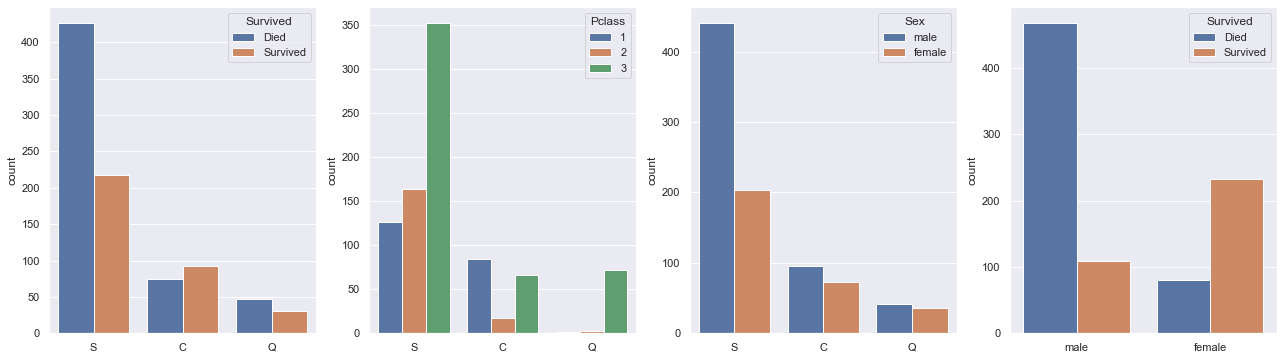

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(22,6))
sns.countplot(x=train_data['Embarked'], hue=train_data['Survived'].map({0: "Died", 1: "Survived"}), ax=axes[0])
sns.countplot(x=train_data['Embarked'], hue=train_data['Pclass'], ax=axes[1])
sns.countplot(x=train_data['Embarked'], hue=train_data['Sex'], ax=axes[2])
sns.countplot(x=train_data['Sex'], hue=train_data['Survived'].map({0: "Died", 1: "Survived"}), ax=axes[3])
for i in range(4):
    axes[i].set_xlabel('')
plt.show()

Com essa informação, olhamos agora quais foram esses dois passageiros que estão com NaN em 'Embarked'.

In [11]:
train_data['Embarked'][train_data['Embarked'].isna()]

PassengerId
62     NaN
830    NaN
Name: Embarked, dtype: object

Arrá, passageiros 62 e 830

In [12]:
train_data.loc[[62,830]]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


Ambas as passageiras sobreviveram! Sabemos que ambas eram da classe 1, logo, é bem provável que subiram ou em 'S' ou em 'C'.

Não causará impactos enormes caso sejam erroneamente alocadas. Dito isto, ambas serão colocadas em 'S'

In [13]:
train_data.loc[62, 'Embarked'] = 'S'
train_data.loc[830, 'Embarked'] = 'S'

In [14]:
train_data[categoric_columns].isna().sum(), test_data[categoric_columns].isna().sum()

(Name        0
 Sex         0
 Ticket      0
 Embarked    0
 dtype: int64,
 Name        0
 Sex         0
 Ticket      0
 Embarked    0
 dtype: int64)

Resolvido!

## NANs: numéricos

### 'Age'

In [15]:
train_data[numerics_columns].isna().sum(), test_data[numerics_columns].isna().sum()

(Pclass      0
 Age       177
 SibSp       0
 Parch       0
 Fare        0
 dtype: int64,
 Pclass     0
 Age       86
 SibSp      0
 Parch      0
 Fare       1
 dtype: int64)

Existem NaNs na coluna Age nos 2 arquivos e na coluna Fare apenas no arquivo de teste.

----------------------------------
Aqui vamos mudar uma coisa. Da última vez, substituimos a idade pela média geral. Mas como podemos ver pelo gráfico abaixo, a sobrevivência de jovens é bem diferente da do geral. Vamos trabalhar com isso.

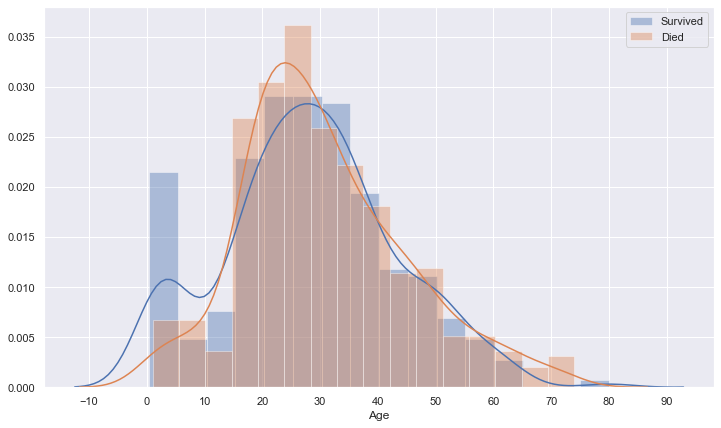

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))
sns.distplot(train_data['Age'][train_data['Survived'] == 1], label='Survived', ax=ax)
sns.distplot(train_data['Age'][train_data['Survived'] == 0], label='Died', ax=ax)
ax.set_xticks(np.arange(-10,100,10))
plt.legend()
plt.show()

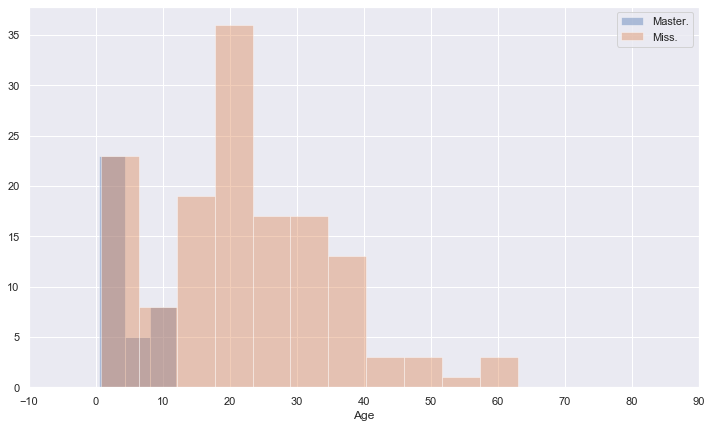

In [17]:
aux_train_data = train_data.copy()
aux_test_data = test_data.copy()

# aux_train_data['Name'] contém agora apenas o nome da família do passageiro, e não mais seu nome completo.
aux_train_data['Name'] = train_data['Name'].apply(lambda x: x.split()[1])
aux_test_data['Name'] = test_data['Name'].apply(lambda x: x.split()[1])

fig, ax = plt.subplots(1, 1, figsize=(12,7))
sns.distplot(aux_train_data['Age'][aux_train_data['Name'] == 'Master.'], label='Master.', kde=False, ax=ax)
sns.distplot(aux_train_data['Age'][aux_train_data['Name'] == 'Miss.'], label='Miss.', kde=False, ax=ax)
ax.set_xticks(np.arange(-10,100,10))
plt.legend()
plt.show()

Jovens tendem a sobreviver mais, especialmente crianças de 0 a 5 anos.

In [18]:
refer_names = aux_train_data.groupby(by='Name').size().sort_values(ascending=False)
r_refer_names = list(refer_names.index[refer_names > 10])

Dessa vez, vamos checar o nome do indivíduo e atribuir a média de acordo com a designação de seu nome. Vamos usar as 4 designações mais frequentes.

Lembrar de fazer isso para o teste e para o treinamento.

In [19]:
print("NANs antes treino: ", train_data['Age'].isna().sum())
print("NANs antes teste: ", test_data['Age'].isna().sum())

for name in r_refer_names:
    mean = train_data['Age'][aux_train_data['Name'] == name].mean()
    train_data['Age'][aux_train_data['Name'] == name] = train_data['Age'][aux_train_data['Name'] == name].apply(lambda x: mean if str(x)[0] == 'n' else x)
    
    mean = test_data['Age'][aux_test_data['Name'] == name].mean()
    test_data['Age'][aux_test_data['Name'] == name] = test_data['Age'][aux_test_data['Name'] == name].apply(lambda x: mean if str(x)[0] == 'n' else x)

print("\nNANs antes treino: ", train_data['Age'].isna().sum())
print("NANs antes teste: ", test_data['Age'].isna().sum())

train_data['Age'] = train_data['Age'].fillna(value=train_data['Age'].mean())
test_data['Age'] = test_data['Age'].fillna(value=test_data['Age'].mean())

print("\nNANs antes treino: ", train_data['Age'].isna().sum())
print("NANs antes teste: ", test_data['Age'].isna().sum())

NANs antes treino:  177
NANs antes teste:  86

NANs antes treino:  3
NANs antes teste:  2

NANs antes treino:  0
NANs antes teste:  0


C:\Users\chris\Anaconda3\envs\PytorchML\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\chris\Anaconda3\envs\PytorchML\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [20]:
train_data[numerics_columns].isna().sum(), test_data[numerics_columns].isna().sum()

(Pclass    0
 Age       0
 SibSp     0
 Parch     0
 Fare      0
 dtype: int64,
 Pclass    0
 Age       0
 SibSp     0
 Parch     0
 Fare      1
 dtype: int64)

Done!!

### 'Fare'

In [21]:
test_data['Fare'][test_data['Fare'].isna()]

PassengerId
1044   NaN
Name: Fare, dtype: float64

Hmm, passageiro 1044. Vejamos

In [22]:
test_data.loc[[1044]]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


Bom, temos informações a respeito de sua classe, seu sexo, sua idade e onde ele embarcou. Vamos ver os dados e tentar achar a melhos solução para seu Fare.

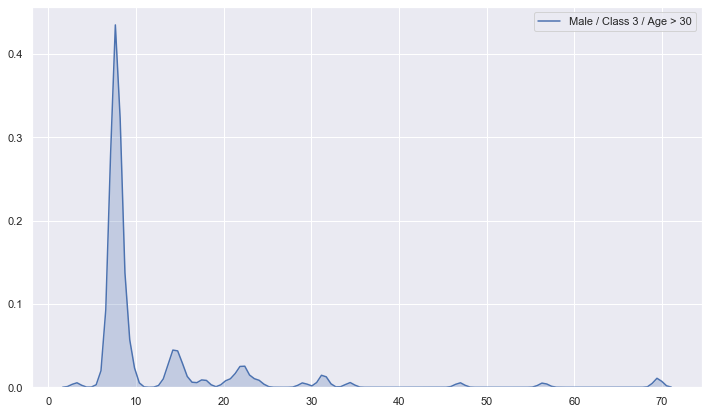

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))
sns.kdeplot(test_data['Fare'][(test_data['Sex'] == 'male') & (test_data['Pclass'] == 3)], label='Male / Class 3 / Age > 30', shade=True, ax=ax)
#ax.set_xticks(np.arange(-40,100,10))
#ax.set_xlim(-40,100)
plt.legend()
plt.show()

In [24]:
test_data[(test_data['Sex'] == 'male') & (test_data['Pclass'] == 3) & (test_data['Age'] > 35)]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
917,3,"Robins, Mr. Alexander A",male,50.0,1,0,A/5. 3337,14.5000,S
932,3,"Karun, Mr. Franz",male,39.0,0,1,349256,13.4167,C
934,3,"Goldsmith, Mr. Nathan",male,41.0,0,0,SOTON/O.Q. 3101263,7.8500,S
1026,3,"Dintcheff, Mr. Valtcho",male,43.0,0,0,349226,7.8958,S
1031,3,"Goodwin, Mr. Charles Frederick",male,40.0,1,6,CA 2144,46.9000,S
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S
1066,3,"Asplund, Mr. Carl Oscar Vilhelm Gustafsson",male,40.0,1,5,347077,31.3875,S
1120,3,"Everett, Mr. Thomas James",male,40.5,0,0,C.A. 6212,15.1000,S
1152,3,"de Messemaeker, Mr. Guillaume Joseph",male,36.5,1,0,345572,17.4000,S


Obsevamos que o preço da passagem para 1 única pessoa da classe 3 sem levar parentes ou irmãos / cônjugues é em torno de 7.85.
Logo, vamos atribuir este valor a ele e seguir a vida.

In [25]:
test_data.loc[1044, 'Fare'] = 7.8500

In [26]:
test_data[numerics_columns].isna().sum()

Pclass    0
Age       0
SibSp     0
Parch     0
Fare      0
dtype: int64

Resolvido!

# Encoding Categorical Data

Verificamos agora se os dtypes estão corretos por coluna antes de aplicarmos o um método de encoding categórico.

Para realizarmos o encoding dos nossos dados, precisamos definir a estratégia que iremos utilizar. As possíveis soluções são:
- One Hot Encoding
- Count Encoding
- Target Encoding
- Singular Value Decomposition

E para isso precisamos antes decidir o que podemos extrair de features dos dados.


In [27]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Temos informações suficientes nas colunas Pclass, Sex e Embarked.

Podemos separar a coluna 'Name' em 2 novas features: Family e Titles. Para isso, vamos unir o teste ao arquivo de treinamento em um arquivo novo. Mas tudo o que assumirmos deve vir unicamente do set de treinamento.

In [28]:
all_data_c1 = train_data.drop('Survived', axis=1).append(test_data).copy()

Vamos aproveitar e pegar um valor mais apropriado para 'Fare'. Vamos pegar o valor total e dividir pelo tamanho do grupo, que equivale à soma de 'SibSp' e 'Parch' + 1.

Extraimos a família. Depois, o título.

In [29]:
all_data_c1['Family'] = all_data_c1['Name'].apply(lambda x: x.split()[0][:-1])
all_data_c1['Title'] = all_data_c1['Name'].apply(lambda x: x.split()[1])

all_data_c1.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Family,Title
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Braund,Mr.
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Cumings,Mrs.
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Heikkinen,Miss.
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Futrelle,Mrs.
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Allen,Mr.


Perfeito.

Feito isso, jogamos a coluna 'Name' fora, pois o nome em si do passageiro não nos traz informação.

In [30]:
all_data_c1.drop('Name', axis=1, inplace=True)
all_data_c1.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Family,Title
PassengerId,,,,,,,,,,
1,3,male,22.0,1,0,A/5 21171,7.2500,S,Braund,Mr.
2,1,female,38.0,1,0,PC 17599,71.2833,C,Cumings,Mrs.
3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Heikkinen,Miss.
4,1,female,35.0,1,0,113803,53.1000,S,Futrelle,Mrs.
5,3,male,35.0,0,0,373450,8.0500,S,Allen,Mr.


A coluna 'Ticket' só adiciona informação que já está presente nas colunas SibSp e Parch, ou seja, indicando o tamanho de pessoas que foi junto no mesmo grupo. Desta forma, podemos descartá-la.

In [31]:
all_data_c1.drop('Ticket', axis=1, inplace=True)
all_data_c1.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Title
PassengerId,,,,,,,,,
1,3,male,22.0,1,0,7.2500,S,Braund,Mr.
2,1,female,38.0,1,0,71.2833,C,Cumings,Mrs.
3,3,female,26.0,0,0,7.9250,S,Heikkinen,Miss.
4,1,female,35.0,1,0,53.1000,S,Futrelle,Mrs.
5,3,male,35.0,0,0,8.0500,S,Allen,Mr.


In [32]:
all_data_c1.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
Family       object
Title        object
dtype: object

---
---

In [33]:
all_data_c1.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Title
PassengerId,,,,,,,,,
1,3,male,22.0,1,0,7.2500,S,Braund,Mr.
2,1,female,38.0,1,0,71.2833,C,Cumings,Mrs.
3,3,female,26.0,0,0,7.9250,S,Heikkinen,Miss.
4,1,female,35.0,1,0,53.1000,S,Futrelle,Mrs.
5,3,male,35.0,0,0,8.0500,S,Allen,Mr.


In [34]:
#worst_columns = ['Name', 
#                 'Ticket', 
#                 'Family', 
#                 'Title', 
#                 'Family Size',
#                  'Fare'
#                ]
all_data_c_aux = all_data_c1.copy()
#all_data_c_aux = all_data_c_aux.drop(worst_columns, axis=1)

---
---

In [40]:
train_df = all_data_c_aux[:891]
test_df = all_data_c_aux[891:]

In [52]:
train_final = pd.concat((train_data['Survived'], train_df), axis=1)
train_final

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Title
PassengerId,,,,,,,,,,
1,0,3,male,22.000000,1,0,7.2500,S,Braund,Mr.
2,1,1,female,38.000000,1,0,71.2833,C,Cumings,Mrs.
3,1,3,female,26.000000,0,0,7.9250,S,Heikkinen,Miss.
4,1,1,female,35.000000,1,0,53.1000,S,Futrelle,Mrs.
5,0,3,male,35.000000,0,0,8.0500,S,Allen,Mr.
...,...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.000000,0,0,13.0000,S,Montvila,Rev.
888,1,1,female,19.000000,0,0,30.0000,S,Graham,Miss.
889,0,3,female,21.846154,1,2,23.4500,S,Johnston,Miss.


In [41]:
test_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Title
PassengerId,,,,,,,,,
892,3,male,34.500000,0,0,7.8292,Q,Kelly,Mr.
893,3,female,47.000000,1,0,7.0000,S,Wilkes,Mrs.
894,2,male,62.000000,0,0,9.6875,Q,Myles,Mr.
895,3,male,27.000000,0,0,8.6625,S,Wirz,Mr.
896,3,female,22.000000,1,1,12.2875,S,Hirvonen,Mrs.
...,...,...,...,...,...,...,...,...,...
1305,3,male,32.050847,0,0,8.0500,S,Spector,Mr.
1306,1,female,39.000000,0,0,108.9000,C,Oliv,y
1307,3,male,38.500000,0,0,7.2500,S,Saether,Mr.


In [53]:
dep_var = 'Survived'
cat_names = ['Pclass', 'Sex', 'Embarked', 'Family', 'Title']
cont_names = ['Age', 'SibSp', 'Parch', 'Fare']
procs = [FillMissing, Categorify, Normalize]

In [81]:
val_pct = 0.8
data = TabularDataBunch.from_df(path='.', 
                                df=train_final, 
                                dep_var=dep_var, 
                                valid_idx=list(range(int(891*val_pct), 891)), 
                                procs=procs, 
                                cat_names=cat_names, 
                                cont_names=cont_names,
                                bs=16)

In [82]:
data.show_batch()

Pclass,Sex,Embarked,Family,Title,Age,SibSp,Parch,Fare,target
3,female,S,Lindblom,Miss.,1.1285,-0.4962,-0.4698,-0.5087,0
3,male,S,Niskanen,Mr.,0.6781,-0.4962,-0.4698,-0.5051,1
2,male,S,Matthews,Mr.,0.0023,-0.4962,-0.4698,-0.4008,0
3,male,S,Reed,Mr.,0.1817,-0.4962,-0.4698,-0.5190,0
1,female,S,Silvey,Mrs.,0.6781,0.4434,-0.4698,0.4806,1


In [83]:
size = 5
emb_szs = {col: size for col in cat_names}
emb_szs

{'Pclass': 5, 'Sex': 5, 'Embarked': 5, 'Family': 5, 'Title': 5}

In [84]:
learn = tabular_learner(data, layers=[200,100], emb_szs=emb_szs, metrics=accuracy)

In [85]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.629338,0.520995,0.787709,00:23
1,0.582073,0.419549,0.832402,00:23
2,0.519779,0.388018,0.843575,00:23


In [86]:
learn.save('stage-1_model-2')

In [ ]:
#learn.load('stage-1')

In [88]:
learn.fit_one_cycle(1, 1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.464117,0.392522,0.849162,00:23


In [89]:
learn.save('stage-2_model-2')

In [131]:
predicts = []
for row, col in test_df.iterrows():
    predicts.append(learn.predict(col)[1].item())

In [136]:
output_df = pd.DataFrame({"PassengerId": test_df.index, "Survived": predicts})
output_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [139]:
output_df.to_csv('./Submissions/sub10_fastai.csv', index=False)